# AtLAST Telescope Simulator - Continuum Emission 

One of the key first light instruments for AtLAST will be some kind of continuum camera, operating at at least one waveband at a time.  This Jupyter notebook creates a simplistic simulation of what we can expect the performance of that telescope/instrument combination to be using the AtLAST Sensitivity Calculator as its starting point.

This notebook is provided as an example of how to setup a telescope simulation for AtLAST using the Sensitivity Calculator.  You can either modify it to suit your own use case / input file, or create your own using this as a guide.  

## What this Simulator *can* do:
* Take observing constraints in the same way the sensitivity calculator does
* Import a user suplied FITS file to simulate observing
* Convolve the FITS file to the resolution expected at the requested observing frequency
* Add a constant gaussian noise level to the image consistent with what AtLAST would expect to obtain (either as specified, or given the amount of integration time requested)


## What this Simulator *can't* do:
* Simulate any spacings between individual detectors/pixels (out of scope with no instrument specification)
* Simulate fall off in sensitivity as a function of distance from pointing centre / chopping constraints (out of scope with no detailed calibration strategy analysis)


## Stepping through this example Notebook

This example notebook is provided as a reference/guide on how to setup an AtLAST simulation given an input FITS file.  The steps below include:

1. Setup the simulator (importing libraries, setting up plotting routines, etc)
2. Input the user specified quantities (time/sensitivity request, observing parameters, input FITS file, etc)
3. Convolve the input file to the resolution expected for an AtLAST observation at the given input frequency
4. Compare the input image to the expected instrument footprint (using number of pixels)
4. Determine the noise level to apply to the image
5. Apply a gaussian noise level to the image
6. Inform the user how many instrument footprints are required to image their FoV.





# Setup The Simulator

Below we import all of the relevant python packages for the sensitivity calculation and telescope simulation, including setting up for importing and displaying FITS images

There are also cells which setup functions for use later in the notebook.

## Import the AtLAST Sensitivity Calculator package

In [53]:
from atlast_sc.calculator import Calculator

## Import astronomy specific packages

In [54]:
# to use astropy coordinates and units
import astropy.units as u  # for ensuring units are treated properly
import astropy.constants as const # to make use of the astropy constants package

# to handle FITS files
from astropy.io import fits # to import and manipulate FITS files
from astropy.wcs import WCS # to use WCS information from the FITS headers

# to use astropy convolution functions
from astropy.convolution import Gaussian2DKernel,convolve_fft

# to reproject the convolved image onto a new grid
from reproject import reproject_interp

## Visualisation Imports

In [55]:
#Import Matplotlibs pyplot package

import matplotlib.pyplot as plt

# Import the Rectangle patch to draw the FoV on the final image
from matplotlib.patches import Rectangle

# show the plots inline
%matplotlib inline

# to allow for wide figures as required
plt.rcParams['figure.figsize'] = [18, 8]

## Imports for Gaussian noise

In [56]:
# gaussian noise imports
import numpy as np
import math

## User defined functions used in the rest of this notebook

Here we define all of the functions to be used later

In [57]:
# downsampling function that changes the relevant keywords in the user provided header by scaling them down by a factor of `factor`

def downsample(header,factor):
    for axis in (1,2):
        header = header.copy()
        cd = 'CDELT{0:d}'.format(axis)
        cp = 'CRPIX{0:d}'.format(axis)
        na = 'NAXIS{0:d}'.format(axis)
        scalefactor = 1./factor
        header[cp] =header[cp]*scalefactor
        header[cd] = header[cd]*factor
        header[na] = int(header[na]*scalefactor)
    return header

# Input User Specified Quantities

Here we generate an instance of the sensitivity calculator which we use for the rest of this simulation notebook.  The first part of this section shows you what the default settings are for the calculator to:
1) Show what the default settings are
2) Show the naming convention for the user editable parameters

We then go through changing some of those parameters and displaying how that changed the variables used for the sensitivity or integration time calculation, followed  by setting the number of pixels to be simulated in this notebook, and the input FITS image to be used in the simulation.  The simulator assumes a fully sampled array of pixels arranged in a square because we don't know the exact properties of any of the instruments expected for AtLAST.  

## Initialise calculator and see default parameters

In [58]:
# create an instance of the calculator
calculator = Calculator()
#show the default values used in the calculation
print(calculator.user_input)

t_int: 100.0 s
sensitivity: 3.0 mJy
bandwidth: 100.0 MHz
obs_freq: 100.0 GHz
n_pol: 2.0 GHz
weather: 25.0 GHz
elevation: 45.0 deg


Listed above are the parameters most commonly edited in the sensitivity calculator. Note that both integration time and sensitivity are listed here, while the calculator only uses one of them at a time to derive the other.  In addition to `calculator.user_input`, there are two other files that could be output here:

`calculator.instrument_setup`: Gives a number of changable parmeters such as the telescope diameter - for those looking to see the effects of having a smaller diameter

`calculator.derived_parameters`: Using the input parameters, there are a number of parameters the simulator derives. Users can inspect those values by printing this out.


## Change some of the input parameters

Now that we know what the variable names are for the input parameters, we can change some of them to reflect the simulated observation we want to make

In [59]:
# set an integration time
calculator.t_int = 3000 *u.s

# change the observing frequency and bandwidth and see how the user input changes
calculator.obs_freq = 460.*u.GHz
calculator.bandwidth = 4.*u.GHz

# print out the input parameters to show that they've changed
print(calculator.user_input)

t_int: 3000.0 s
sensitivity: 3.0 mJy
bandwidth: 4.0 GHz
obs_freq: 460.0 GHz
n_pol: 2.0 GHz
weather: 25.0 GHz
elevation: 45.0 deg


## Specify the image to be used in the simulation

Ideally, here you would specify an oversampled base image to which the simulator can attach a gaussian noise level derived from the sensitivity calculator. In this example, we use a JWST/MIRI 7.7 micron image of Carina because its quite large on the sky, and better resolution than we expect to get with AtLAST at any wavelength. The input FITS file is not included in this directory and can be downloaded from the [NASA archive](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMFILTERED%22%2C%22inputText%22%3A%5B%7B%22paramName%22%3A%22obs_collection%22%2C%22niceName%22%3A%22obs_collection%22%2C%22values%22%3A%5B%22JWST%22%5D%2C%22valString%22%3A%22JWST%22%2C%22isDate%22%3Afalse%2C%22separator%22%3A%22%3B%22%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22JWST%22%7D%2C%7B%22paramName%22%3A%22filters%22%2C%22niceName%22%3A%22filters%22%2C%22values%22%3A%5B%22F770W%22%5D%2C%22valString%22%3A%22F770W%22%2C%22isDate%22%3Afalse%2C%22separator%22%3A%22%3B%22%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22F770W%22%7D%2C%7B%22paramName%22%3A%22proposal_id%22%2C%22niceName%22%3A%22proposal_id%22%2C%22values%22%3A%5B%5D%2C%22valString%22%3A%222731%22%2C%22isDate%22%3Afalse%2C%22freeText%22%3A%222731%22%2C%22displayString%22%3A%222731%22%7D%5D%2C%22position%22%3A%22undefined%2C%20undefined%2C%20undefined%22%2C%22paramsService%22%3A%22Mast.Caom.Filtered%22%2C%22title%22%3A%22MAST%3A%20%20Advanced%20Search%201%22%2C%22tooltip%22%3A%22JWST%3B%20F770W%3B%202731%3B%20%22%2C%22columns%22%3A%22*%22%2C%22columnsConfig%22%3A%22Mast.Caom.Cone%22%7D).



In [60]:
#import an example image
filename = 'jw02731-o002_t017_miri_f770w_i2d.fits'  #4M pixel MIRI image
hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)

/home/mark/mambaforge/envs/sens-calc/lib/python3.10/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-06-11T01:49:29.555' from MJD-BEG.
Set DATE-AVG to '2022-06-11T07:01:06.422' from MJD-AVG.
Set DATE-END to '2022-06-11T12:12:35.756' from MJD-END'.
  warnings.warn(
/home/mark/mambaforge/envs/sens-calc/lib/python3.10/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -78.755358 from OBSGEO-[XYZ].
Set OBSGEO-B to   -34.248172 from OBSGEO-[XYZ].
Set OBSGEO-H to 1697610262.935 from OBSGEO-[XYZ]'.
  warnings.warn(


## Set the number of pixels to be simulated

Here we setup the number of pixels expected for the instrument. For a spectral line reciever, we hope to achieve of order 1000 pixels, while for a continuum camera, we expect much closer to $10^6$.  Because this is a continuum example, we'll use $10^6$ as the number of pixels here.

As noted above, we cannot take pixel spacing into account because we don't have specifications for our cameras. As such, this simulator simply places a square box containing as close to the input number of pixels as possible (scaling up slightly to provide an integer number of pixels in either spatial direction).

In [61]:
# simulator/imaging settings
Npix_detector = 1e6
len_detector = math.ceil(np.sqrt(Npix_detector))

## Calculate pixel scale / beam size based on observing frequency and telescope diameter

In [62]:
# pull the telescope radius from the instrument_setup
radius = calculator.instrument_setup.dish_radius.value
# pull the observing frequency from the user inputs
freq = calculator.user_input.obs_freq.value

theta = ((1.2* const.c / (freq * (2*radius) ))*u.radian).to('arcsec')
print(f'Given the requested observing frequency, the resolution of AtLAST will be {theta:0.2f}')

Given the requested observing frequency, the resolution of AtLAST will be 3.23 arcsec


## Set the pixel sampling of the convolved image

When the image is convolved to the resolution of AtLAST, we need to downsample the pixel scaling accordingly. Usual rule of thumb is 3-5 pixels per resolution element. That sampling is set here for use in section 4

In [63]:
sampling = 5  # provide 5 pixels for each resolution element of the instrument

# Display the input image and convolve it to the resolution of AtLAST

Now that we have an input image, and the sensitivity calculator setup, we can begin the process of simulating an observation with AtLAST.  The first step in that process is to convolve the input image to the resolution expected for AtLAST.  Below we:

* Show the image at its original resolution
* Derive the smoothing kernel required to convolve that image to the resolution of AtLASToriginal resolution image
* Resample the input image to the AtLAST resolution by applying that convolution
* Show a small area of the input image at original and convolved resolution to show what happened
* Compare the size of the input image to the expected instrument footprint (instrument field of view)

*Specific to the JWST input image*: The intensity of this image was divided by a factor of 100 to make the image fainter than what it truly is (median flux ~49 Mjy/str or 1.1 mJy/arcsec^2). That was done to show the sensitivity of AtLAST in greater detail. Using the native sensitivity of the JWST image would give an excellent signal to noise ratio in a matter of seconds.  Here we want to show what AtLAST can do with slightly deeper integrations.

## Show the original image

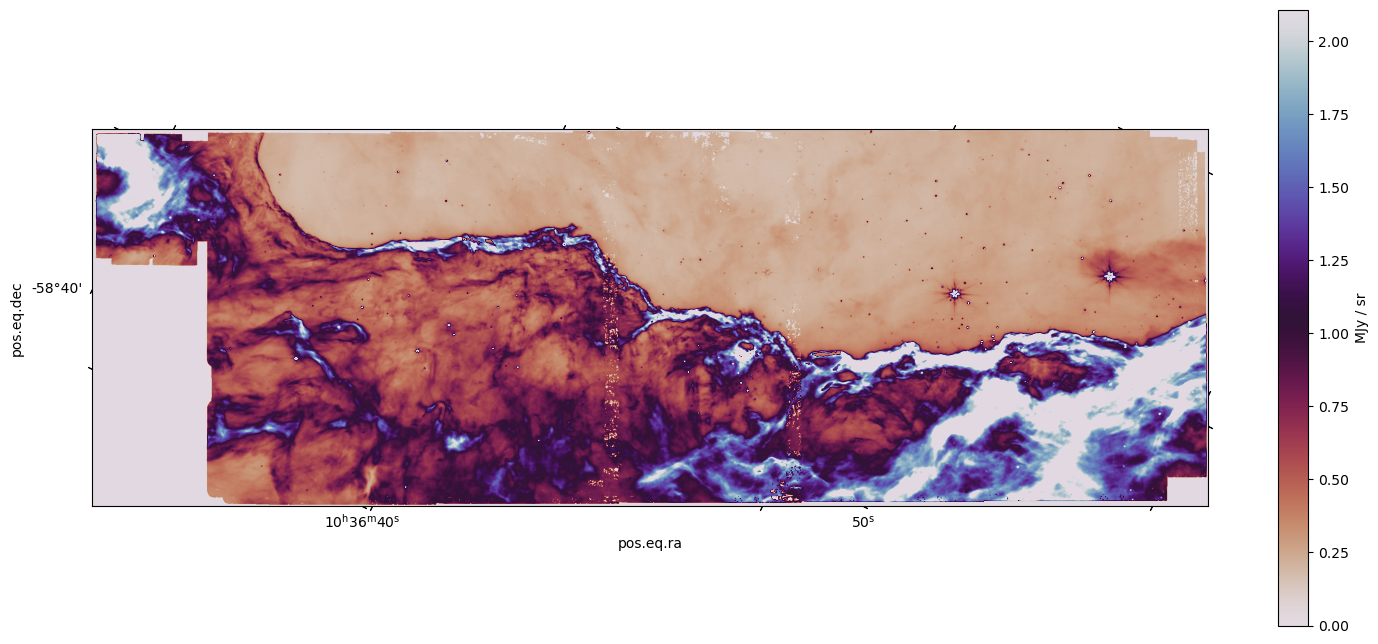

In [64]:
# read the data from the input FITS file
data = hdu.data
# give data units from header
# divide by 100 to make the sensitivity of the input image 'better' than current tech. is able to give
data=  data*u.Unit(hdu.header['bunit'])/100

# set the data plotting limits by finding the min/max values over most of the image (removing edges), and scaling the max to 10% of max to avoid spikes and saturated pixels
vmin,vmax = np.abs(np.nanmin(data[10:-10,10:-10])*1.05).value,np.nanmax(data[10:-10,10:-10]).value*0.1
noise = np.nanstd(data)

# show the input data
fig = plt.figure()
ax = fig.add_subplot(projection=wcs)  # add the WCS information to the plot
im = ax.imshow(data,vmin = vmin,vmax=vmax,origin='lower',cmap='twilight_r')
# add a colorbar
cbar = plt.colorbar(im)
cbar.set_label(data.unit)

## Convolve the image to the resolution of AtLAST

Use the header information of the original image to find its pixel scale, and then calculate a convolving kernel based on the ratio of AtLASTs resolution and that pixel scale.  With that convolving kernel initialised, use it to convolve the data to AtLASTs resolution

In [65]:
# convolve the image to the beamsize at the requested observing frequency
pix_scale = (hdu.header['cdelt1']*u.deg).to('arcsec')
kern = (theta/pix_scale).value
kernel = Gaussian2DKernel(x_stddev=kern)

# convolve the data with the gaussian kernel, and save the results for the reprojection below.
astropy_conv = convolve_fft(data,kernel)



## Downsample to the AtLAST pixel scale

Convolving the input image above doesn't change the size of the pixels in the original image, only smooths it.  Here we use the `reproject` package to do that downsampling on the data, and use the downsamplig function to update the header keywords accordingly.

In [66]:
#create a downsampled header using the 'downsample' function and sampling set in sections 2.5 and 3.6 (respectively)
ds_header = downsample(hdu.header,kern/sampling)

# reproject the convolved image to the downsampled header
array,footprint = reproject_interp((astropy_conv,hdu.header),ds_header)


/home/mark/mambaforge/envs/sens-calc/lib/python3.10/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-06-11T01:49:29.555' from MJD-BEG.
Set DATE-AVG to '2022-06-11T07:01:06.422' from MJD-AVG.
Set DATE-END to '2022-06-11T12:12:35.756' from MJD-END'.
  warnings.warn(
/home/mark/mambaforge/envs/sens-calc/lib/python3.10/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -78.755358 from OBSGEO-[XYZ].
Set OBSGEO-B to   -34.248172 from OBSGEO-[XYZ].
Set OBSGEO-H to 1697610262.935 from OBSGEO-[XYZ]'.
  warnings.warn(


## Resample to AtLAST resolution

Plot (a cutout of) the original and the convolved/regridded images to show how the convolution has changed how the data look. The code uses the `crpix` keywords in the header to determine the centre of the cutout. The same cutout is created for the convolved and resampled image using the convolution kernel and sampling parameter

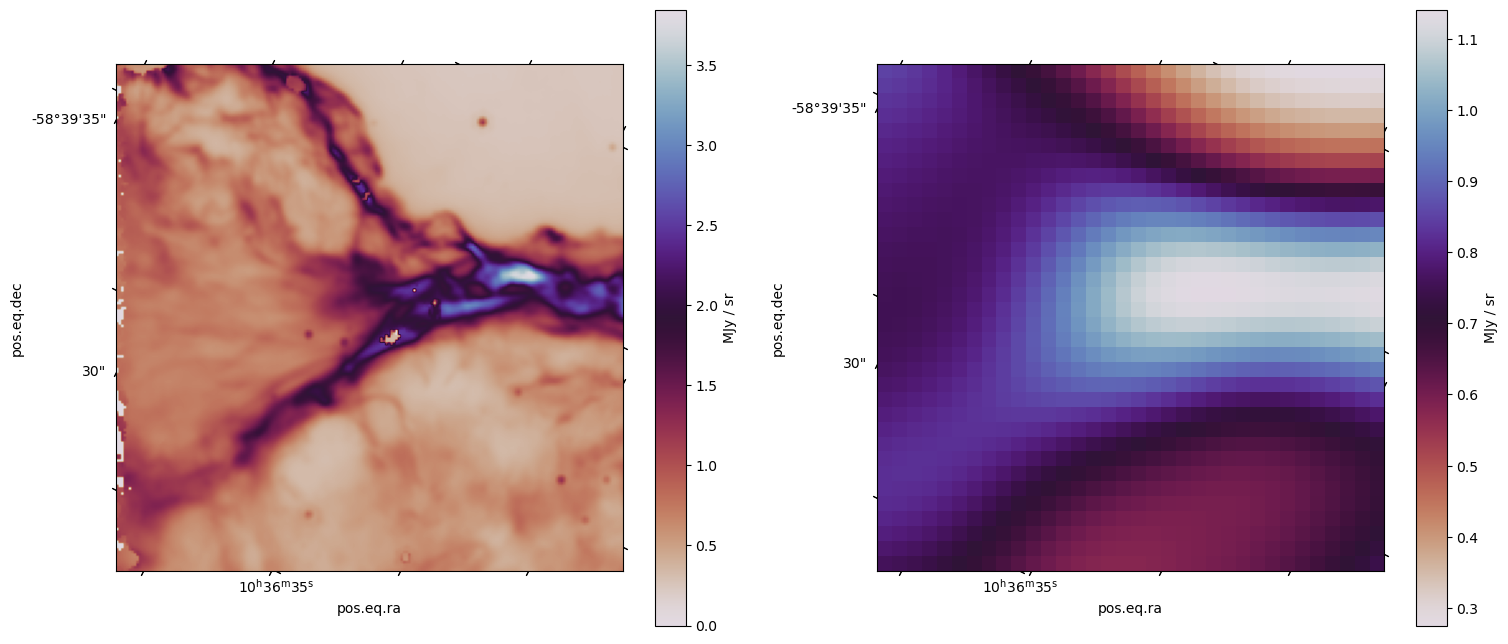

In [67]:

# create a cutout with `delt' pixels on each side centred on crpix1 and crpix2
x,y = int(hdu.header['crpix2']),int(hdu.header['crpix1']) # python and FITS standards switch around the order of x/y and crpix1/2. that's why these *look* backwards, but aren't
delt = 100  # only show a small number of pixels around the reference pixels

# use the sampling kernel to setup the same area in the resampled image
samp = kern/sampling
x1,y1 = int(x/samp),int(y/samp)
delt1 = int(delt/samp)


# put the plotting areas for each image (and the wcs information) into 2 arrays t obe called in the plotting loop below
plot_area = [data[x-delt:x+delt, y-delt:y+delt],array[x1-delt1:x1+delt1, y1-delt1:y1+delt1]]
head_wcs = [wcs, WCS(ds_header)]

# show the plots
fig = plt.figure()
for i in [0,1]:
    ax = fig.add_subplot(1,2,i+1,projection=head_wcs[i])
    im = ax.imshow(plot_area[i],origin='lower',cmap='twilight_r')
    # add a colorbar
    cbar = plt.colorbar(im)
    cbar.set_label(data.unit)

# Evaluate image size compared to observing footprint

As the number of pixels in a detector varies, so does the amount of the telescope field of view it can capture in a single setup. Here we look at whether the input image is large enough to fill the instrument footprint 

**Image smaller than footprint**

If the image is not big enough to fill the instrument footprint, then the image will be padded out with zeros to show how large the instrument footprint would be in comparison to the input image. In this case the convolved input image is centred in the new, zero padded, array, and the header is updated accordingly. Here, the instrument footprint is also plotted on the image.

**Image larger than footprint**

If the image is larger than the instrument footprint, then the code below draws a red box in the centre of the image to indicate the footprint, and also outputs how many observations (and therefore on-source integration time) are required to observe the entire image, rounding up the number of footprints to an integer value.



/home/mark/mambaforge/envs/sens-calc/lib/python3.10/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-06-11T01:49:29.555' from MJD-BEG.
Set DATE-AVG to '2022-06-11T07:01:06.422' from MJD-AVG.
Set DATE-END to '2022-06-11T12:12:35.756' from MJD-END'.
  warnings.warn(
/home/mark/mambaforge/envs/sens-calc/lib/python3.10/site-packages/astropy/wcs/wcs.py:725: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -78.755358 from OBSGEO-[XYZ].
Set OBSGEO-B to   -34.248172 from OBSGEO-[XYZ].
Set OBSGEO-H to 1697610262.935 from OBSGEO-[XYZ]'.
  warnings.warn(


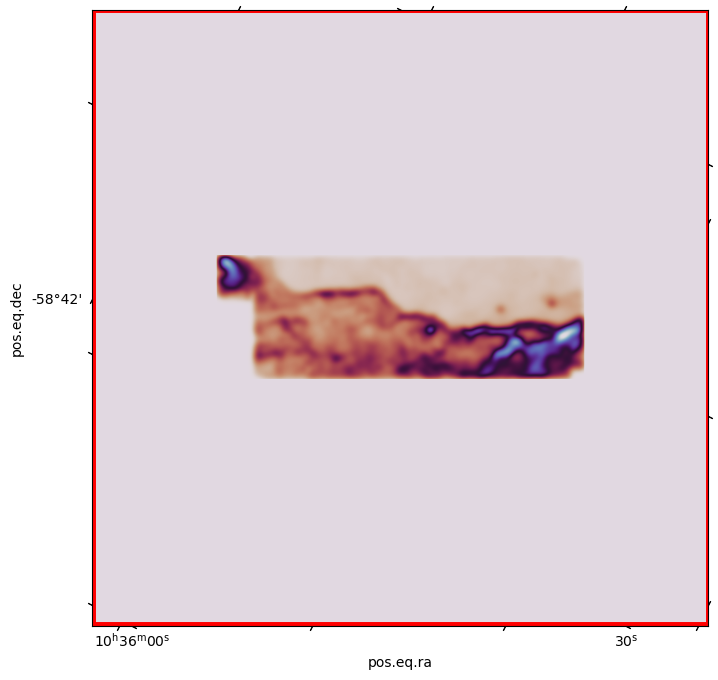

In [68]:
# get the shape of the input (convolved) image
y1,x1 = array.shape  #badkwards here to make the rest make sense (see note above about python vs. FITS handling of first axis)

# find which is larger, the x or y coordinate, or the number of detector pixels across that dimension
pad = np.max((x1,len_detector)),np.max((y1,len_detector))


header = ds_header.copy()  #create a new copy of the header information

# determine if the image is smaller than the instrument footprint in either x or y

# yes, one or more dimensions are smaller
if x1 <= len_detector or y1 <= len_detector:
    for i in (0,1):

        cp = 'CRPIX{0:d}'.format(i+1)
        na = 'NAXIS{0:d}'.format(i+1)
        header[cp] = int(math.ceil(pad[i]/2))
        header[na] = int(pad[i])

    # find the padding required to create that array & add zeros to the data
    pads = [int((len_detector-x1)/2),int((len_detector-y1)/2)]
    pads.insert(1,pads[0])
    pads.insert(-1,pads[-1])
    pads = [0 if i < 0 else i for i in pads]
    
    # create the padded data array using the numpy 'pad' module
    array = np.pad(array,((pads[2:]),(pads[:2])),'constant',constant_values=0)

# no, the image is larger than the instrument footprint    
else:
    # because the image is larger than the footprint, just pass the original array along for plotting
    array = array    

fig = plt.figure()
ax = fig.add_subplot(projection=WCS(header))
ax.imshow(array,origin='lower',cmap='twilight_r')

# plot the detector footprint on the image (regardless of whether the image needed padding.
#find where the first (bottom left) pixel of the rectangle should be
startx = np.max((int(x1/2 - len_detector/2),0))
starty = np.max((int(y1/2 - len_detector/2),0))

# use the Rectangle patch to specify a box starting at (startx,starty) with dimensions of len_detector x len_detector
rect = Rectangle((startx,starty),len_detector,len_detector,edgecolor='r',facecolor='None',lw=5)
ax.add_patch(rect)




# Determine the noise level to add to the image

With the input image sufficiently processed, and the size of the instrument footprint compared to the image size, we can now setup use the sensitivity calculator to derive an integration time or sensitivity limit.

In the example below, we use an integration time to derive a sensitivity limit, and then apply that noise level to the image.

## Calculate sensitivity based on integration time

Using the integration time set in section 3.2, we can calculate the single pixel sensitivity using the sensitivity calculator.

In [69]:
# copy the integration time from section 3.2
integration_time = calculator.t_int

# use telescope size to convert point source sensitivity to flux density 
# (assuming no beam dilution)
calculated_sensitivity = calculator.calculate_sensitivity(integration_time).to(u.mJy)/theta**2
print("Sensitivity: {:0.5f} for an integration time of {:0.2f} ".format(calculated_sensitivity, integration_time))

Sensitivity: 0.01996 mJy / arcsec2 for an integration time of 3000.00 s 


## Add Gaussian noise to the image based on serived sensitivity calculation.

Using the sensitivity above, create a noise map using the numpy gaussian (random normal) distribution module

In [70]:
# sigma of the distribution comes from the sensitivity calculator
sigma = calculated_sensitivity.to('MJy/sr').value
mean = 0 + sigma 

gaussian_noise = np.random.normal(mean, sigma, (array.shape))*u.MJy/u.sr

# add the noise to the image
noisy_image = array+gaussian_noise.value

# Plot the final results

Now, with the gaussian noise level applied to the convolved and resampled image, we have the final simulated AtLAST observation to plot.  

Below we plot 4 images, representative of the different steps followed through in this notebook:

* the original data
* the data convolved to the resolution of AtLAST
* the Gaussian noise map applied to the image
* the final image

For the final 3, a single instrument footprint has been added to the image, as above in section 5.

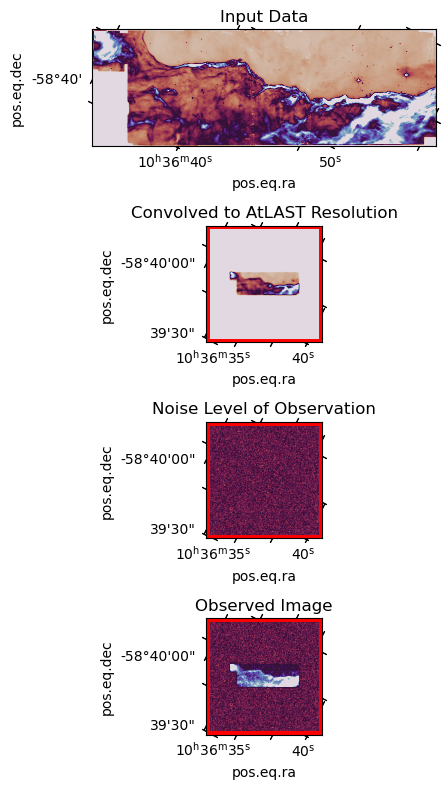

In [71]:
inputs = [data,array,gaussian_noise,noisy_image]
titles = ['Input Data', 'Convolved to AtLAST Resolution',
          'Noise Level of Observation', 'Observed Image']

from astropy.visualization.wcsaxes import Quadrangle

fig = plt.figure()
for i in range(0,len(inputs)):
    ax = fig.add_subplot(4,1,i+1, projection=wcs)
    ax.imshow(inputs[i],vmin = vmin,vmax=vmax,origin='lower',cmap='twilight_r')
    if i > 0:  # don't plot the instrument footprint on the original image (the way its pixels are counted is different)
        rect = Rectangle((startx,starty),len_detector,len_detector,edgecolor='r',facecolor='None',lw=5)
        ax.add_patch(rect)
    ax.set_title(titles[i])
  
plt.tight_layout()

## Mapping Constraints

Here, we evaluate whether mapping is required, and if so, the (integer) number of instrument footprints required to cover the input image.  The integration times reported here are a lower limit, and do not include any of the following:

* array configurations that aren't fully sampled
* array configurations that aren't square
* off source (calibration time)

In [72]:
#find how many pointings of an N pixel detector would be required to observe the full image

# number of pixels in the final image
a,b = noisy_image.shape
Npix_img = a*b
N_int_actual = Npix_img/Npix_detector
# find the whole number of footprints required to map the whole image
N_int_ceiling = math.ceil(N_int_actual)

# based on the number of footprints required, create the appropriate text to append to the overall output print statement.
if N_int_ceiling > 1:
    footprint = f'To fully image your map will require {N_int_ceiling} integrations, and a total on source time of {integration_time*N_int_ceiling}'

elif N_int_ceiling<= 1:
    footprint = f'The total on source integration time is {integration_time} (assuming the detector is fully sampled).'

# tell the user how long their observation will take
print(f'There are {Npix_img} pixels in the image, and {Npix_detector} on the detector, \
so {N_int_actual} integrations are required.  {footprint}')


There are 999000 pixels in the image, and 1000000.0 on the detector, so 0.999 integrations are required.  The total on source integration time is 3000.0 s (assuming the detector is fully sampled).
